In [1]:
# first, let's import some packages that we need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<div class="alert alert-success" role="alert">
<h2> Assignment 1: The impact of context (40 points) </h2><br>
Besides the bandits encountered above, we can construct a wide variety of different versions.
    
For example, the type of reward distribution can be varied. We have already encountered _binomial rewards_ in the <code>draw_from_k_bandits</code>. For this bandit, reward distributions indicated the reward probablity associated with each action. We have also already encountered _Gaussian rewards_ in the <code>draw_from_k_gaussian_bandits</code>. Contrary to the binomial rewards, determinstic rewards do not include binomial noise, but Gaussian noise.  

Moreover, we can make a distinction between _stationary (stable)_ and _walking (volatile)_ reward distributions. So far, we have only encountered fixed rewards distributions. Rewards were always drawn from a stable environment and did not change over time. We simulated a walking bandit by generating multiple different walks and glueing them together (flattening). 

For truely walking rewards distributions, noise is added to the defining parameters of the distribution. For example, on every new trial of our <code>draw_from_k_bandits</code>, the new reward probablity could be set to the old rewards probability plus some normal noise with mean 0 and standard deviation 0.05. Please note, that this makes it necessary to define bounds, as rewards probabilities (e.g., binomial) need to be set between 0 and 1. Gaussian rewards should not wander off too much but rather stay between 0 and 100.


> Set up the 4 possible bandits with the following properties (20 points) <br>
> 1. Binomial rewards with fixed reward probabilities (as implemented already in <code>generate_uniform_bandit</code>)
> 2. Binomial rewards with walking reward probabilities
> 3. Gaussian rewards with fixed mean rewards (bound between 0 and 1)
> 4. Gaussian rewards with walking mean rewards (bound between 0 and 1)

> Visualize the bandits. For visualization, use one-armed variants. Plot their true reward probabilites, obtained rewards, etc. (10 points)

> Plot how the performance of our weighted average, softmax RL agents differs between these bandits. For this excersise, use two-armed bandits. For the agent, fix the learning rate (alpha) to 0.1 and the softmax inverse temperature (beta) to 2. (10 points)

</div>

In [2]:
#Assignment 1, part A


def binominal(n_trials, prob):  
    reward_samples = np.random.binomial(1,prob,n_trials)
    probabilities = np.full(n_trials, prob)
    return reward_samples, probabilities

def binominal_walking(n_trials, prob, noise=0.05):
    noisy_prob=[prob] 
    for i in range(n_trials-1):
        new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)
        noisy_prob.append(new_prob)
    reward_samples = np.random.binomial(1, noisy_prob, n_trials)  
    return reward_samples, noisy_prob

def gaussian(n_trials, mean_reward):  
    reward_samples = np.random.normal(size=n_trials, loc=mean_reward, scale=1)   
    means = np.full(n_trials, mean_reward)
    return reward_samples, means

def gaussian_walking(n_trials, mean_reward, noise = 0.05): 
    noisy_means=[mean_reward] 
    for i in range(n_trials-1):
        noisy_means.append(noisy_means[-1]+np.random.normal(loc=0, scale=noise))
    reward_samples = np.random.normal(loc=noisy_means, scale=1)  # Generate samples directly
    return reward_samples, noisy_means



def draw_from_k_bandits(n_trials, parameters, bandit, noise=0.05):
    n_bandits = len(parameters)  # how many arms?
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs = np.empty((n_bandits, n_trials))
    for i, parameter in enumerate(parameters):
        if bandit is gaussian_walking:
            reward_samples[i,:], reward_probs[i,:] = bandit(n_trials, parameter, noise)  
        else:
            reward_samples[i,:], reward_probs[i,:] = bandit(n_trials, parameter)
    return reward_samples, reward_probs




In [3]:
#Part 1.B
n_trials = 1000
prob = [0.7]
means = [10]

In [4]:

def calculate_means_average(n_trials, parameters, agent):
    reward_samples, reward_parameters = draw_from_k_bandits(n_trials, parameters, agent)
    mean_avg = np.empty((1,n_trials+1))  
    for iT in np.arange(n_trials):
        if iT == 0:
            mean_avg[0,0] = 0.5     
        mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[0,iT]-mean_avg[0,iT])
    return mean_avg, reward_parameters


def calculate_means_weighted_average(n_trials, parameters, agent, lr=0.1):
    reward_samples, reward_parameters = draw_from_k_bandits(n_trials, parameters, agent)
    mean_avg = np.empty((1,n_trials+1))  
    for iT in np.arange(n_trials):
        if iT == 0:
            mean_avg[0,0] = 0.5     
        mean_avg[0,iT+1] = mean_avg[0,iT] + (lr)*(reward_samples[0,iT]-mean_avg[0,iT])
    return mean_avg, reward_parameters


C:\Users\matis\AppData\Local\Temp\ipykernel_23440\955472976.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)


Text(0.5, 0.98, 'Incremental update estimation')

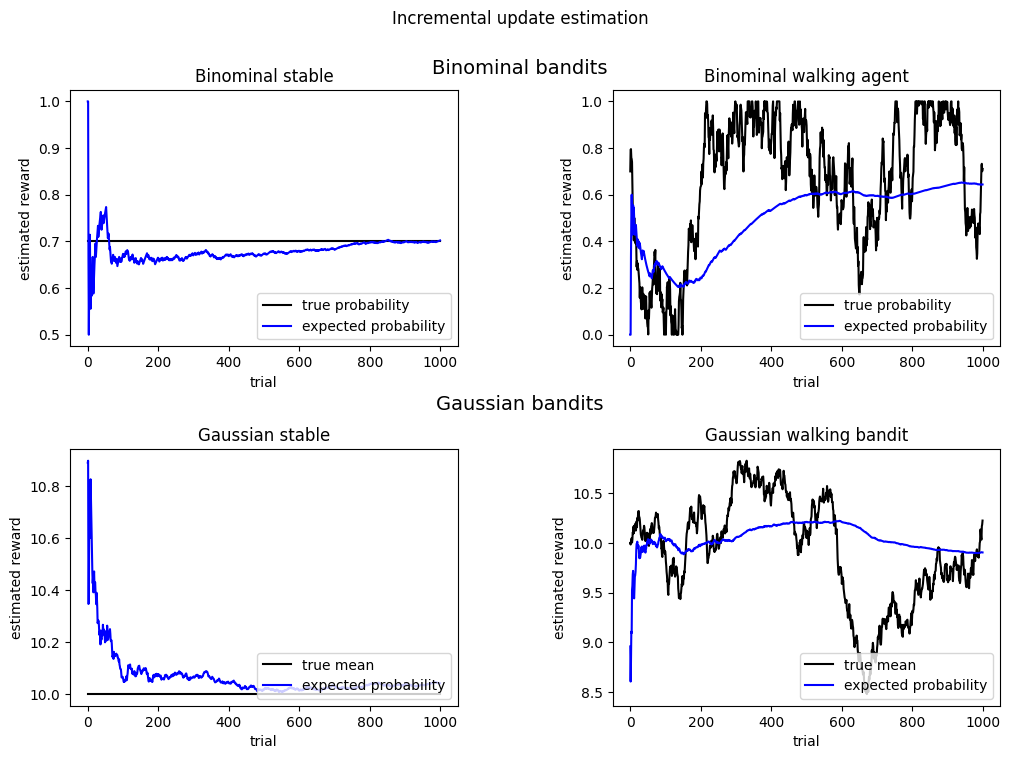

In [5]:

mean_avg_b, reward_probs_b = calculate_means_average(n_trials, prob, binominal)
mean_avg_bw, reward_probs_bw = calculate_means_average(n_trials, prob, binominal_walking)
mean_avg_g, reward_mean_g = calculate_means_average(n_trials, means, gaussian)
mean_avg_gw, reward_mean_gw = calculate_means_average(n_trials, means, gaussian_walking)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axs[0, 0].plot(np.arange(n_trials),reward_probs_b[0,:],'-k',label = 'true probability')
axs[0, 0].plot(np.arange(n_trials),mean_avg_b[0,1:],'-b',label ='expected probability')  
axs[0, 0].set_xlabel('trial')
axs[0, 0].set_ylabel('estimated reward')
axs[0, 0].set_title('Binominal stable')
axs[0, 0].legend(loc="lower right") 


axs[0, 1].plot(np.arange(n_trials),reward_probs_bw[0,:],'-k',label = 'true probability')
axs[0, 1].plot(np.arange(n_trials),mean_avg_bw[0,1:],'-b',label ='expected probability') 
axs[0, 1].set_xlabel('trial')
axs[0, 1].set_ylabel('estimated reward') 
axs[0, 1].set_title('Binominal walking agent')
axs[0, 1].legend(loc="lower right") 

axs[1, 0].plot(np.arange(n_trials),reward_mean_g[0,:],'-k',label = 'true mean')
axs[1, 0].plot(np.arange(n_trials),mean_avg_g[0,1:],'-b',label ='expected probability') 
axs[1, 0].set_xlabel('trial')
axs[1, 0].set_ylabel('estimated reward')
axs[1, 0].set_title('Gaussian stable')
axs[1, 0].legend(loc="lower right") 

axs[1, 1].plot(np.arange(n_trials),reward_mean_gw[0,:],'-k',label = 'true mean')
axs[1, 1].plot(np.arange(n_trials),mean_avg_gw[0,1:],'-b',label ='expected probability') 
axs[1, 1].set_xlabel('trial')
axs[1, 1].set_ylabel('estimated reward')
axs[1, 1].set_title('Gaussian walking bandit')
axs[1, 1].legend(loc="lower right") 


fig.text(0.5, 0.90, 'Binominal bandits', ha='center', fontsize=14)  # Top row title
fig.text(0.5, 0.48, 'Gaussian bandits', ha='center', fontsize=14) 
fig.suptitle('Incremental update estimation')

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\955472976.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)


Text(0.5, 0.98, 'Learning update estimation')

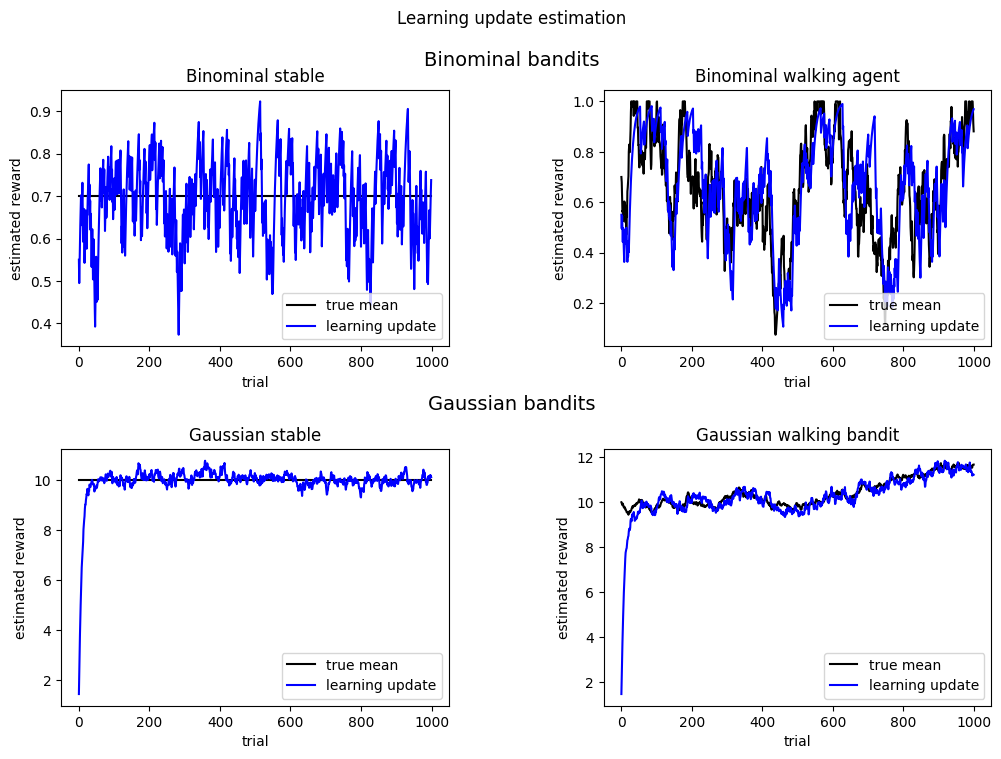

In [6]:

mean_avg_b, reward_probs_b = calculate_means_weighted_average(n_trials, prob, binominal)
mean_avg_bw, reward_probs_bw = calculate_means_weighted_average(n_trials, prob, binominal_walking)
mean_avg_g, reward_mean_g = calculate_means_weighted_average(n_trials, means, gaussian)
mean_avg_gw, reward_mean_gw = calculate_means_weighted_average(n_trials, means, gaussian_walking)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axs[0, 0].plot(np.arange(n_trials),reward_probs_b[0,:],'-k',label = 'true mean')
axs[0, 0].plot(np.arange(n_trials),mean_avg_b[0,1:],'-b',label ='learning update')  
axs[0, 0].set_xlabel('trial')
axs[0, 0].set_ylabel('estimated reward')
axs[0, 0].set_title('Binominal stable')
axs[0, 0].legend(loc="lower right") 


axs[0, 1].plot(np.arange(n_trials),reward_probs_bw[0,:],'-k',label = 'true mean')
axs[0, 1].plot(np.arange(n_trials),mean_avg_bw[0,1:],'-b',label ='learning update') 
axs[0, 1].set_xlabel('trial')
axs[0, 1].set_ylabel('estimated reward') 
axs[0, 1].set_title('Binominal walking agent')
axs[0, 1].legend(loc="lower right") 

axs[1, 0].plot(np.arange(n_trials),reward_mean_g[0,:],'-k',label = 'true mean')
axs[1, 0].plot(np.arange(n_trials),mean_avg_g[0,1:],'-b',label ='learning update') 
axs[1, 0].set_xlabel('trial')
axs[1, 0].set_ylabel('estimated reward')
axs[1, 0].set_title('Gaussian stable')
axs[1, 0].legend(loc="lower right") 

axs[1, 1].plot(np.arange(n_trials),reward_mean_gw[0,:],'-k',label = 'true mean')
axs[1, 1].plot(np.arange(n_trials),mean_avg_gw[0,1:],'-b',label ='learning update') 
axs[1, 1].set_xlabel('trial')
axs[1, 1].set_ylabel('estimated reward')
axs[1, 1].set_title('Gaussian walking bandit')
axs[1, 1].legend(loc="lower right") 


fig.text(0.5, 0.91, 'Binominal bandits', ha='center', fontsize=14) 
fig.text(0.5, 0.48, 'Gaussian bandits', ha='center', fontsize=14) 
fig.suptitle('Learning update estimation')


In [7]:
#Part 1.C

def action_softm(values, beta):

    nOptions = len(values)  # Ensure nOptions matches the number of values
    actions = np.arange(nOptions)  # Create actions array with same length as values
    prob = np.exp(beta * values) / np.sum(np.exp(beta * values))
    action = np.random.choice(actions, size=1, p=prob)  # Choose action based on probabilities
    return int(action)



In [8]:
def run_experiment(parameters, agent, beta=3, n_agents=1000, n_trials=1000, learning_rate=0.1, volatility=0.05):

    rewards_softmax = np.empty((n_agents,n_trials))
    optimum_softmax = np.empty((n_agents,n_trials))
    parameter_history = np.zeros((len(parameters), n_trials))
    for iA in np.arange(n_agents): 
        if agent is gaussian_walking:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent, volatility)
        else:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent)
        parameter_history += reward_param
        #initialize the estimated values for each bandit
        values = np.zeros(len(parameters))
        for iT in np.arange(n_trials):    
            
            #chose action
            action = action_softm(values, beta)
        
            #calculate prediction error
            PE = reward_samples[action][iT]-values[action]
            #update value
            
            values[action] = values[action] + (learning_rate)*PE
            
            #store reward
            optimal_action = np.argmax(reward_param[:, iT])
            optimum_softmax[iA, iT] = 1 if action == optimal_action else 0
            rewards_softmax[iA,iT] = reward_samples[action,iT]
            if action == optimal_action:
                optimum_softmax[iA,iT] = 1
            else:
                optimum_softmax[iA,iT] = 0

    return rewards_softmax, optimum_softmax, parameter_history/n_agents




In [9]:
rewards_b, optimum_b, parameter_history_b = run_experiment( [0.2, 0.8], binominal, n_agents=100, )
rewards_bw, optimum_bw, parameter_history_bw= run_experiment( [0.2, 0.8], binominal_walking, n_agents=100, )
rewards_g, optimum_g, parameter_history_g = run_experiment( [1, 5], gaussian, n_agents=100, )
rewards_gw, optimum_gw, parameter_history_gw = run_experiment( [1, 5], gaussian_walking, n_agents=100)


C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)
C:\Users\matis\AppData\Local\Temp\ipykernel_23440\955472976.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)


Text(0.5, 0.98, 'Average Rewards and Optimal Choices for Different Bandit Types')

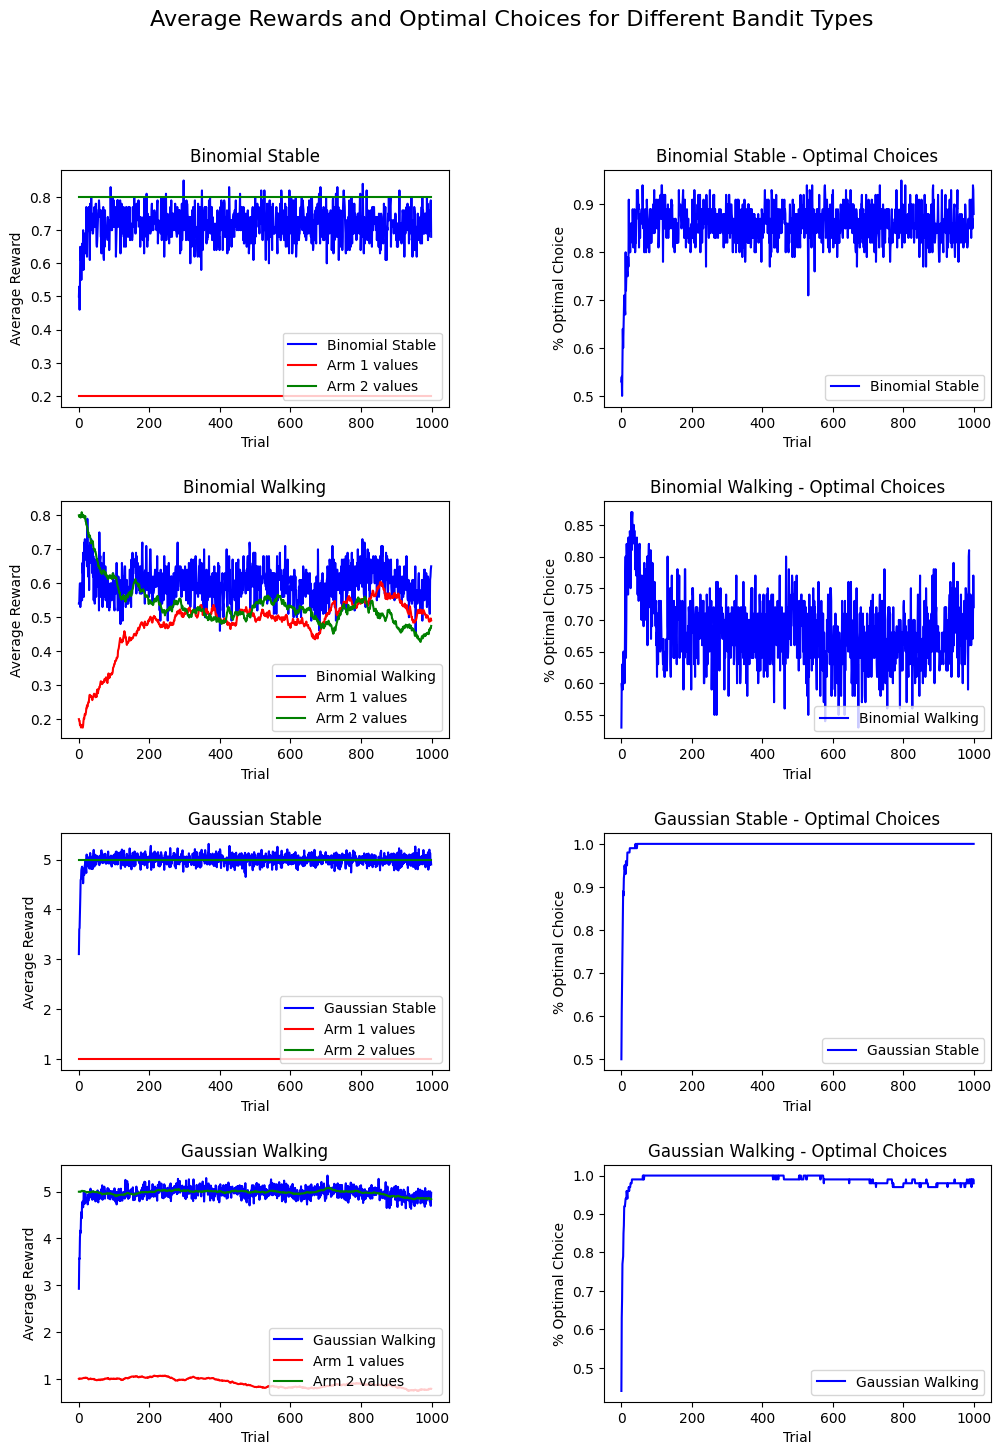

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

def plot(axs, rewards, parameters, optimum, row,  name, n_trials=1000):
    axs[row, 0].plot(np.arange(n_trials), np.mean(rewards, 0), '-b', label=name)
    axs[row, 0].plot(np.arange(n_trials), parameters[0], 'r', label='Arm 1 values')
    axs[row, 0].plot(np.arange(n_trials), parameters[1], 'g', label='Arm 2 values')
    axs[row, 0].legend(loc="lower right")
    axs[row, 0].set_xlabel('Trial')
    axs[row, 0].set_ylabel('Average Reward')
    axs[row, 0].set_title(name)

    axs[row, 1].plot(np.arange(n_trials), np.mean(optimum, 0), '-b', label=name)
    axs[row, 1].legend(loc="lower right")
    axs[row, 1].set_xlabel('Trial')
    axs[row, 1].set_ylabel('% Optimal Choice')
    axs[row, 1].set_title(f'{name} - Optimal Choices')

plot(axs, rewards_b, parameter_history_b, optimum_b, 0,  'Binomial Stable')
plot(axs, rewards_bw, parameter_history_bw, optimum_bw, 1,  'Binomial Walking')
plot(axs, rewards_g, parameter_history_g, optimum_g, 2,  'Gaussian Stable')
plot(axs, rewards_gw, parameter_history_gw, optimum_gw, 3,  'Gaussian Walking')
fig.suptitle('Average Rewards and Optimal Choices for Different Bandit Types', fontsize=16)


<div class="alert alert-success" role="alert">
<h2> Assignment 2: The interaction of agent and context (30 points) </h2><br>

Environmental change is a crucial aspect that any learning agents has to take into account. We have already seen, how different learning rules (average vs. weighted-average) can be (mal)adaptive, dependent on the environment. Now, we are going to have a closer look into this issue and investigate how the speed of environmental change influences performance of our bandit.     

> Set up a bandit with Gaussian rewards and walking reward probabilities (see bandit option 4 in assignment 1) and add an additional parameter for volatility (i.e., the standard deviation of the normal distribution that governs the _walk_)
    
> Before coding, come up with hypotheses. Would you want your learning rate (alpha) to be high or low in a rapidly changing environment? Would you want your inverse temperature (beta) to be higher or lower in rapidly changing environments? (15 points)
    
> Show how the parameters of our agent is traded-off with different speeds of environmental volatility. Could you verify your intuitions as stated in the hypotheses? (15 points)

    
</div>

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


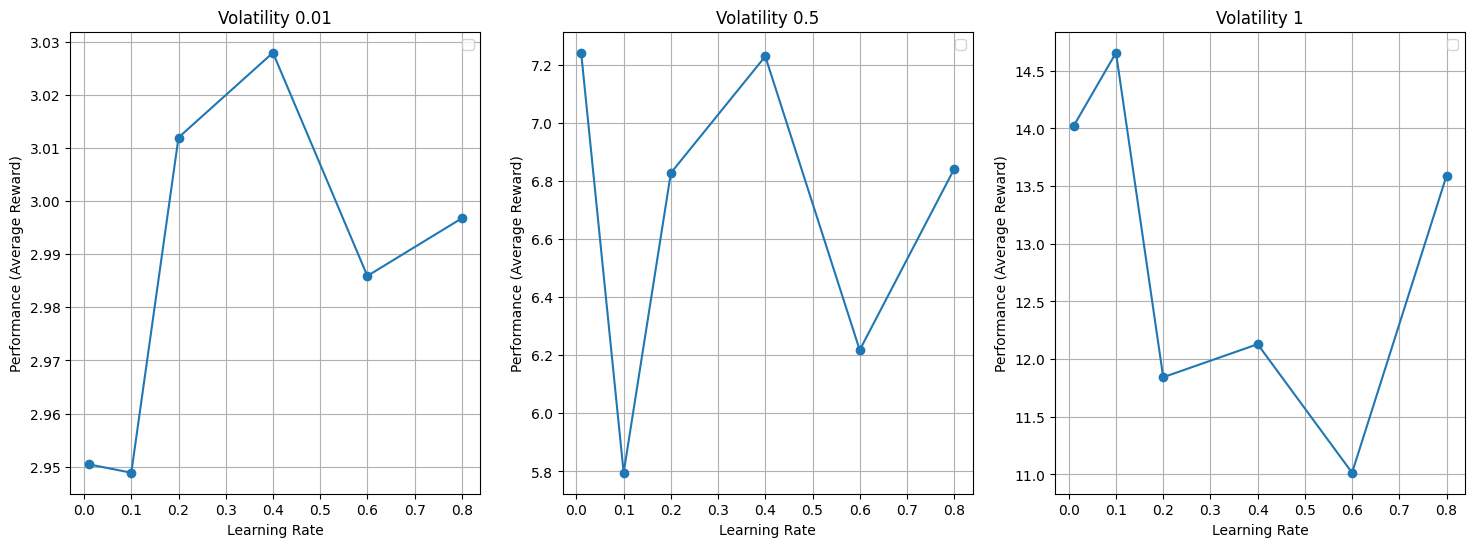

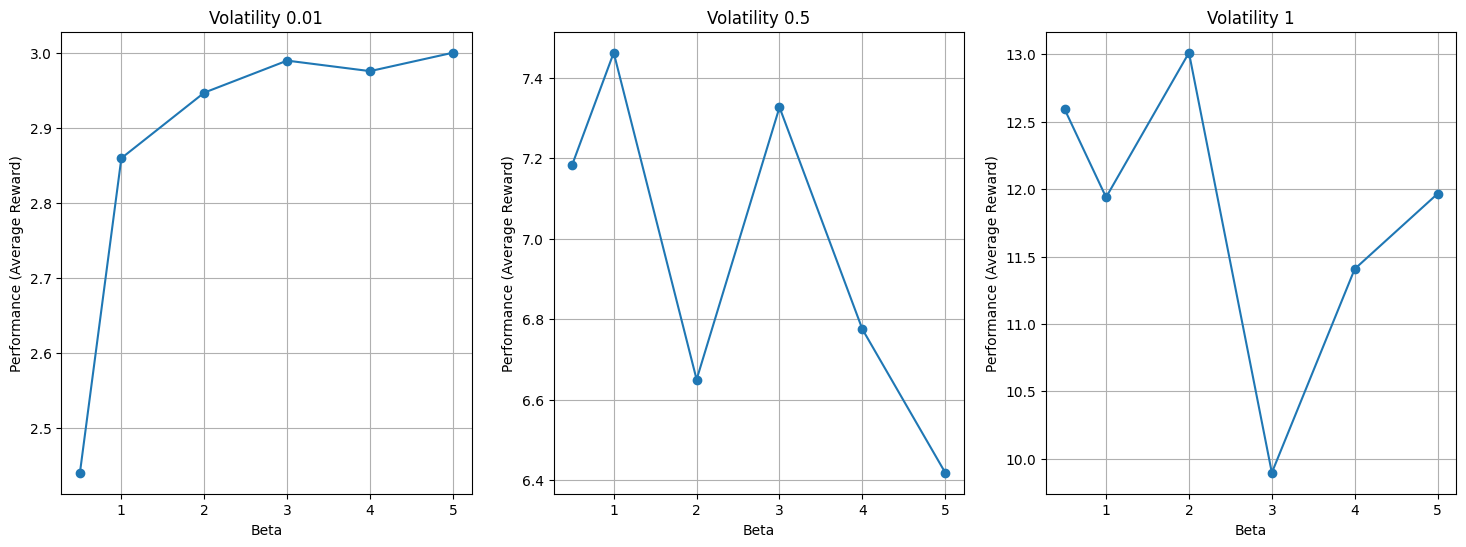

In [11]:
mean_values = [0, 3] 
n_agents = 100
n_trials = 1000
volatilities = [ 0.01, 0.5, 1]
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8]
beta_fixed = 2

lr_results = {}

for vol in volatilities:
    lr_results[vol] = []
    for lr in learning_rates:
        rewards, optimality, _ = run_experiment(mean_values, gaussian_walking, beta=beta_fixed, n_agents=n_agents, n_trials=n_trials, learning_rate=lr, volatility=vol)
        avg_performance = np.mean(rewards) 
        lr_results[vol].append(avg_performance)

# Plotting Learning Rate vs Performance for each volatility
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)

for i, vol in enumerate(volatilities):
    axs[i].plot( learning_rates, lr_results[vol], marker ='o')
    axs[i].set_title(f'Volatility {vol}')
    axs[i].set_xlabel('Learning Rate')
    axs[i].set_ylabel('Performance (Average Reward)')
    axs[i].legend()
    axs[i].grid(True)

plt.show()

#2. Beta vs Performance (for volatilities: 0.1, 0.5, 2)
betas = [0.5, 1, 2, 3, 4, 5]
learning_rate_fixed = 0.1

beta_results = {}

for vol in volatilities:
    beta_results[vol] = []
    for beta in betas:
        rewards, optimality, _ = run_experiment(mean_values, gaussian_walking, beta=beta, n_agents=n_agents, n_trials=n_trials, learning_rate=learning_rate_fixed, volatility=vol)
        avg_performance = np.mean(rewards) 
        beta_results[vol].append(avg_performance)

# Plotting Beta vs Performance for each volatility
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)

for i, vol in enumerate(volatilities):
    axs[i].plot(betas, beta_results[vol], marker='o')
    axs[i].set_title(f'Volatility {vol}')
    axs[i].set_xlabel('Beta')
    axs[i].set_ylabel('Performance (Average Reward)')
    axs[i].grid(True)

plt.show()

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


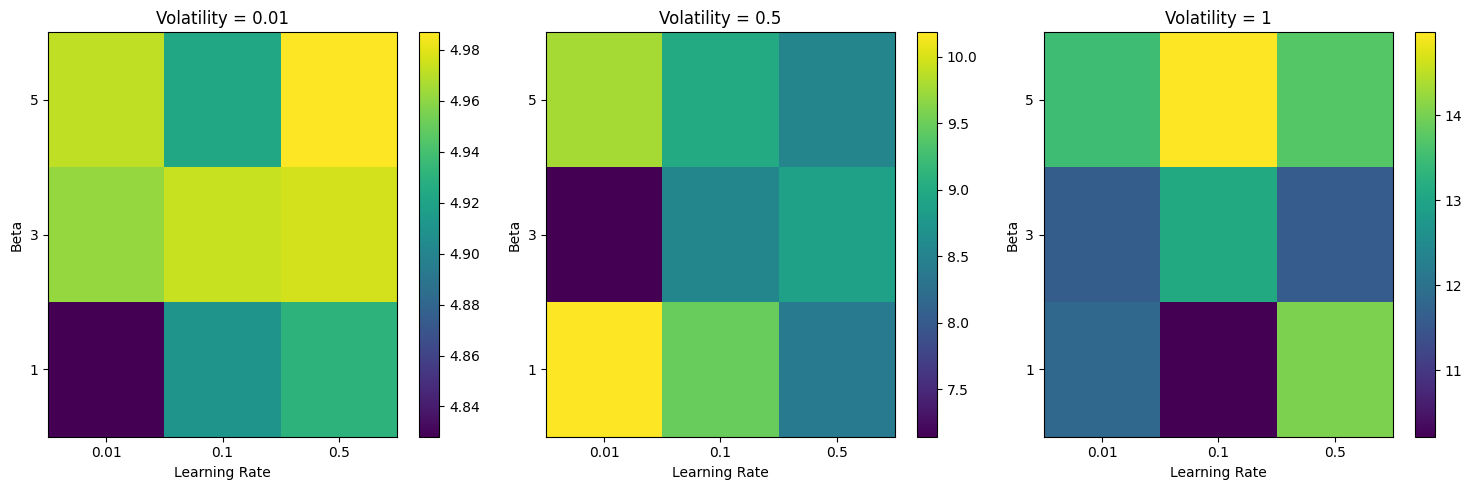

In [12]:
def experiment_tradeoff(parameters, n_agents=100, n_trials=1000, beta_vals=[1, 3, 5], lr_vals=[0.01, 0.1, 0.5], volatilities=[0.01, 0.05, 0.1]):
    results = {}
    
    # Loop over all combinations of beta, learning_rate, and volatility
    for beta in beta_vals:
        for lr in lr_vals:
            for vol in volatilities:
                # Run experiment for current set of parameters
                rewards_softmax, optimum_softmax, _ = run_experiment(parameters, gaussian_walking, beta=beta, n_agents=n_agents, 
                                                                     n_trials=n_trials, learning_rate=lr, volatility=vol)
                
                # Calculate average reward and optimal actions over all agents and trials
                avg_reward = np.mean(rewards_softmax)
                optimal_action_percentage = np.mean(optimum_softmax)
                
                # Store the result for this combination of parameters
                results[(beta, lr, vol)] = {'avg_reward': avg_reward, 'optimal_action_percentage': optimal_action_percentage}
    
    return results


def plot_tradeoff_heatmaps(results, beta_vals, lr_vals, volatilities, metric='avg_reward'):
    fig, axes = plt.subplots(1, len(volatilities), figsize=(15, 5))
    
    for i, vol in enumerate(volatilities):
        
        heatmap = np.zeros((len(beta_vals), len(lr_vals)))
        
        for b_idx, beta in enumerate(beta_vals):
            for lr_idx, lr in enumerate(lr_vals):
                
                heatmap[b_idx, lr_idx] = results[(beta, lr, vol)][metric]
        
        # Plot the heatmap
        ax = axes[i]
        im = ax.imshow(heatmap, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f"Volatility = {vol}")
        ax.set_xlabel("Learning Rate")
        ax.set_ylabel("Beta")
        ax.set_xticks(np.arange(len(lr_vals)))
        ax.set_yticks(np.arange(len(beta_vals)))
        ax.set_xticklabels(lr_vals)
        ax.set_yticklabels(beta_vals)
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Example usage:
parameters = [1, 5]
beta_vals = [1, 3, 5]
lr_vals = [0.01, 0.1, 0.5]
volatilities = [0.01, 0.5, 1]

results = experiment_tradeoff(parameters, beta_vals=beta_vals, lr_vals=lr_vals, volatilities=volatilities)

# Plot heatmaps of avg_reward
plot_tradeoff_heatmaps(results, beta_vals, lr_vals, volatilities, metric='avg_reward')


<div class="alert alert-success" role="alert">
<h2> Assignment 3: Alternatives to performance (30 points) </h2><br>

So far, we have encountered two measures of performance: 
- Overall or average reward collected by the agent
- proportion of optimal (=greedy) choices
    
There is a another way to look at performance: How well do our expectations of the environment match with the true value of the environment? Put differently, how well do our Q-values track the reward probabilities that generate rewards? The idea is simple: The better our estimate about the true values, the better our decision making will be.
    
> Plot the Q values together with the reward probabilities and compare the performance of the same RL agents for binomial and Gaussian rewards in a walking/changing environment. (15 points)     

A simple metric that you could utilize to quantify performance is the correlation coefficient. High correlation means that Qvalues and true probabilities are aligned, with r=1 indicating a perfect match. Low correlation means that Qvalues and true probabilities are not aligned, with r=0 indicating no connection at all.

> Compare the performance of different agents. Can you manually fine-tune the agent's parameters to optimize correlation?  (15 points)


(Please note that averaging correlation coefficients, e.g. between blocks or agents, is a bit tricky. Use Fisher's z  transformation (<code>numpy.arctanh</code>), average, and then transform back (<code>numpy.tanh</code>), to obtain meaningful results. Alternatively you could also estimate one correlation coefficient for ALL data at once.)

 
</div>

[fisher's z](https://en.wikipedia.org/wiki/Fisher_transformation)<br>



In [13]:
def run_experiment_compare(parameters, agent, beta=2, n_agents=1000, n_trials=1000, learning_rate=0.1, volatility=0.05, policy=action_softm):
    n_bandits = len(parameters)
    all_reward_probs = np.empty((n_agents, n_trials)) 
    all_bandit_values = np.empty((n_agents, n_trials)) 
    for iA in np.arange(n_agents): 
        if agent is gaussian_walking:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent, volatility)
        else:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent)

        # keep track of the reward probabilities (for all trials)
        all_reward_probs[iA] = reward_param

        #initialize the estimated values for each bandit
        values = np.zeros(n_bandits)
        
        for iT in np.arange(n_trials):    
            #chose action
            action = policy(values, beta)
        
            #calculate prediction error
            PE = reward_samples[action][iT]-values[action]
            #update value
            values[action] = values[action] + (learning_rate)*PE

            #only works for 1 bandit
            all_bandit_values[iA][iT] = values[0]
            

    return all_bandit_values, all_reward_probs

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)
C:\Users\matis\AppData\Local\Temp\ipykernel_23440\955472976.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)


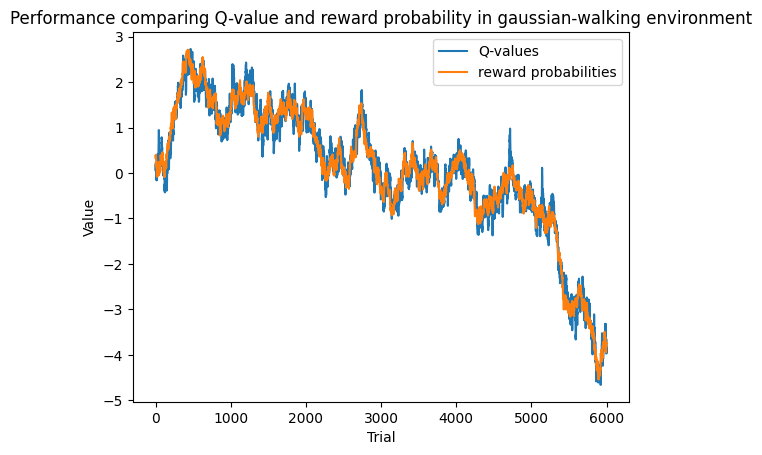

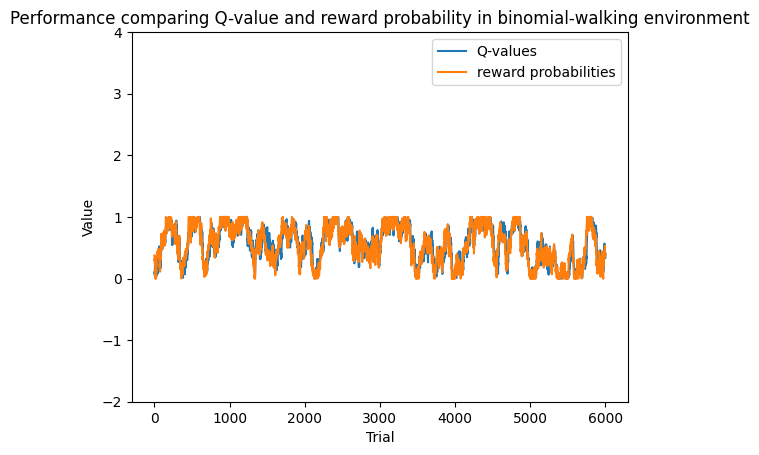

In [14]:

n_trials = 6000
np.random.seed(42)
random_starting_prob = np.random.rand()
q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=2, n_agents=1, n_trials=n_trials, learning_rate=0.1)
q_values_bi, reward_probs_bi = run_experiment_compare([random_starting_prob], agent=binominal_walking, beta=2, n_agents=1, n_trials=n_trials, learning_rate=0.1)
#print(np.mean(q_values, axis=1))
#print(reward_probs)

fig, ax = plt.subplots()  
ax.plot(range(n_trials), q_values[0], label="Q-values")  
ax.plot(range(n_trials), reward_probs[0], label="reward probabilities")
ax.set_title('Performance comparing Q-value and reward probability in gaussian-walking environment')
ax.set_xlabel('Trial')
ax.set_ylabel('Value')
ax.legend()

fig, ax = plt.subplots()  
ax.plot(range(n_trials), q_values_bi[0], label="Q-values")  
ax.plot(range(n_trials), reward_probs_bi[0], label="reward probabilities")
ax.set_title('Performance comparing Q-value and reward probability in binomial-walking environment')
ax.set_ylim(-2, 4)
ax.set_xlabel('Trial')
ax.set_ylabel('Value')
ax.legend()

In [15]:

def avg_corr(cor_coes):
    #calculate average coefficient 
    z_transformed = np.arctanh(cor_coes)
    z_mean = np.mean(z_transformed)
    average_coefficient = np.tanh(z_mean)
    return average_coefficient

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


Average Correlation Coefficient 0.9836729870698663


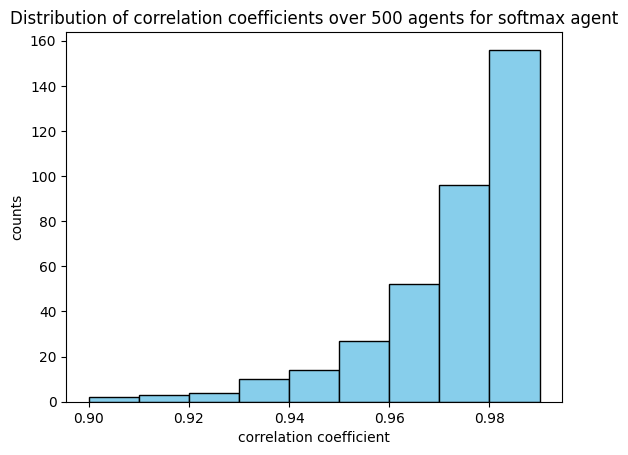

In [16]:

n_trials = 6000
np.random.seed(None)
q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=2, n_agents=500, n_trials=n_trials, learning_rate=0.1)
cor_coes = []
for i in range(len(q_values)):
    correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
    correlation_coefficient = correlation_matrix[0, 1]
    cor_coes.append(correlation_coefficient)


bins = np.arange(0.9, 1, 0.01)  
hist_counts, bin_edges = np.histogram(cor_coes, bins)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), color='skyblue', edgecolor='black', align='edge')
ax.set_title('Distribution of correlation coefficients over 500 agents for softmax agent')
ax.set_xlabel('correlation coefficient')
ax.set_ylabel('counts')

print("Average Correlation Coefficient", avg_corr(cor_coes))

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


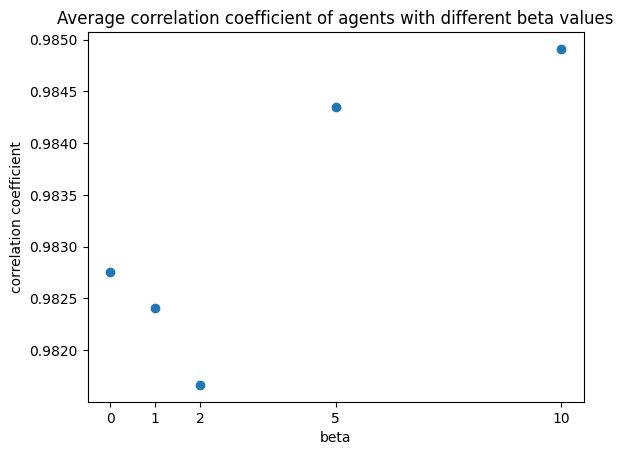

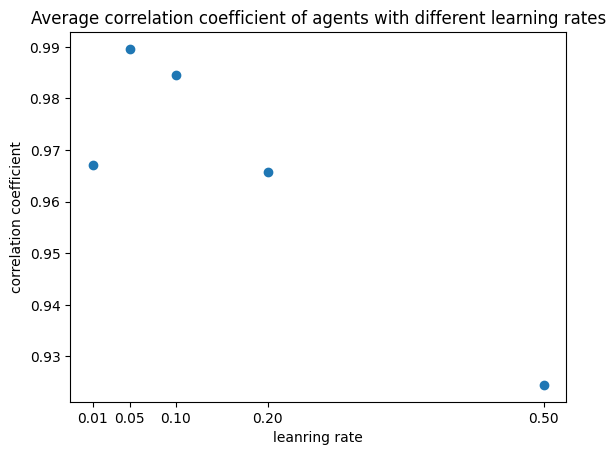

In [17]:
n_trials = 6000
all_avg_coef = []
betas = [0,1,2,5, 10]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
for b in betas:
    q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=b, n_agents=100, n_trials=n_trials, learning_rate=0.1)
    cor_coes = []
    for i in range(len(q_values)):
        correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
        correlation_coefficient = correlation_matrix[0, 1]
        cor_coes.append(correlation_coefficient)

    average_coefficient = avg_corr(cor_coes)
    all_avg_coef.append(average_coefficient)


fig, ax = plt.subplots()
ax.scatter(betas, all_avg_coef)
ax.set_title('Average correlation coefficient of agents with different beta values')
ax.set_ylabel('correlation coefficient')
ax.set_xlabel('beta')
ax.set_xticks(betas)

all_avg_coef = []
for a in learning_rate:
    q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=2, n_agents=50, n_trials=n_trials, learning_rate=a)
    cor_coes = []
    for i in range(len(q_values)):
        correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
        correlation_coefficient = correlation_matrix[0, 1]
        cor_coes.append(correlation_coefficient)

    average_coefficient = avg_corr(cor_coes)
    all_avg_coef.append(average_coefficient)


fig, ax = plt.subplots()
ax.scatter(learning_rate, all_avg_coef)
ax.set_title('Average correlation coefficient of agents with different learning rates')
ax.set_ylabel('correlation coefficient')
ax.set_xlabel('leanring rate')
ax.set_xticks(learning_rate)

C:\Users\matis\AppData\Local\Temp\ipykernel_23440\1773283348.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


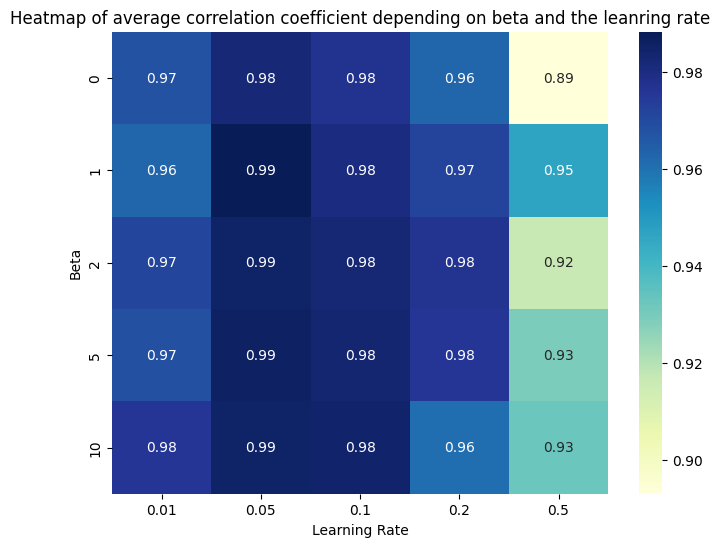

In [19]:
import seaborn as sns
betas = [0,1,2,5,10]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]

# Create an empty array to store the function results
results = np.zeros((len(betas), len(learning_rate)))

# Evaluate the function for each combination of beta and learning_rate
for b, beta in enumerate(betas):
    for j, lr in enumerate(learning_rate):
        q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=beta, n_agents=20, n_trials=n_trials, learning_rate=lr)
        cor_coes = []
        for i in range(len(q_values)):
            correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
            correlation_coefficient = correlation_matrix[0, 1]
            cor_coes.append(correlation_coefficient)

        average_coefficient = avg_corr(cor_coes)
        results[b, j] = average_coefficient

# Plot a heatmap of the results
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, xticklabels=learning_rate, yticklabels=betas, cmap='YlGnBu')
plt.title('Heatmap of average correlation coefficient depending on beta and the leanring rate')
plt.xlabel('Learning Rate')
plt.ylabel('Beta')
plt.show()